downlaod from fashion MNIST  
```
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
```
put them into data/fashion

In [23]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
import imageio
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/fashion', one_hot=True)

Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz


In [5]:
str_labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

In [6]:
img, label = mnist.train.next_batch(10)

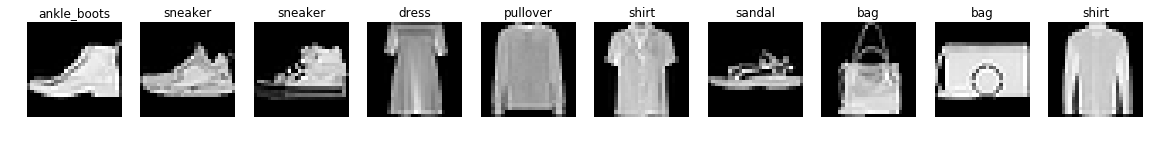

In [7]:
dim = 28

fig, axs = plt.subplots(1, len(img), figsize=(20, 3))

for i, (img, label )in enumerate(zip(img,label)):  
        axs[i].imshow(np.reshape(img, (dim, dim)),cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(str_labels[np.argmax(label)])
plt.show()

In [8]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(w)

def bias_variable(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)

def conv2d(x, filt):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        filt is a filter. filt.shape is [filter_height, filter_width, in_channels, out_channels]
    """
    
    return tf.nn.conv2d(x, filt, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def variable_summaries(var):  
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [9]:
height = 28
width = 28
image_size = height * width
g1 = None

with tf.Graph().as_default() as g1:
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=[None, image_size], name='x-input')
        y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')

    with tf.name_scope('input_reshape'):    
        x_image = tf.reshape(x, [-1, height, width, 1])
        tf.summary.image('input',  x_image, 10)

    with tf.name_scope("conv1"):
        with tf.name_scope('weights'):
            W_conv1 = weight_variable([5,5,1,32])
            variable_summaries(W_conv1)        
        with tf.name_scope('biases'):
            b_conv1 = bias_variable([32])
            variable_summaries(b_conv1)
        h_conv1 = conv2d(x_image, W_conv1) + b_conv1
        variable_summaries(h_conv1)
        
    with tf.name_scope("relu1"):
        h_conv1_act = tf.nn.relu(h_conv1)
    
    with tf.name_scope("pool1"):   
        h_pool1 = max_pool_2x2(h_conv1_act)
        variable_summaries(h_pool1)

    with tf.name_scope("conv2"):
        with tf.name_scope('weights'):
            W_conv2 = weight_variable([5,5,32,64])
            variable_summaries(W_conv2) 
        with tf.name_scope('biases'):    
            b_conv2 = bias_variable([64])
            variable_summaries(b_conv2)
        h_conv2 = conv2d(h_pool1, W_conv2) + b_conv2
        variable_summaries(h_conv2)
        
    with tf.name_scope("relu2"):
        h_conv2_act = tf.nn.relu(h_conv2)

    with tf.name_scope("pool2"):
        h_pool2 = max_pool_2x2(h_conv2_act)
        variable_summaries(h_pool2)
    
    with tf.name_scope("pool2_flat"):
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    
    with tf.name_scope("fc1"):
        with tf.name_scope('weights'):
            W_fc1 = weight_variable([7 * 7 * 64, 1024])
        with tf.name_scope('biases'):   
            b_fc1 = bias_variable([1024])
        h_fc1 =tf.matmul(h_pool2_flat, W_fc1) + b_fc1

    with tf.name_scope("relu3"):
        h_fc1_act = tf.nn.relu(h_fc1)
        
    with tf.name_scope("dropout"):
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1_act, keep_prob)

    with tf.name_scope("fc2"):
        with tf.name_scope('weights'):
            W_fc2 = weight_variable([1024,10])
        with tf.name_scope('biases'): 
            b_fc2 = bias_variable([10]) 
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    with tf.name_scope("loss"):
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        tf.summary.scalar('cross_entropy', loss)

    with tf.name_scope("optimizer"):
        opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope("accuracy"):
        correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

In [10]:
import tensorboard as tb 
tb.show_graph(g1)

In [11]:
n_iter = 500
batch_size = 50
log_dir= "logs"
if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)



with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    
    for i in tqdm(range(n_iter)):
        batch = mnist.train.next_batch(batch_size)
        _ = sess.run(opt, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.6})
        
        if i % 100 == 0:
            train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={
                  x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
            train_writer.add_summary(summary, i)
        
    test_accuracy, test_summary, = sess.run([accuracy, merged], 
                                           feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    test_writer.add_summary(test_summary, 0)
    print('test accuracy %g' % test_accuracy)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

step 0, training loss 3.91779, training accuracy 0.06
step 100, training loss 0.681338, training accuracy 0.7
step 200, training loss 0.624854, training accuracy 0.74
step 300, training loss 0.442823, training accuracy 0.88
step 400, training loss 0.476181, training accuracy 0.86

test accuracy 0.829


```
tensorboard --logdir=logs
```

# similarity

In [12]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    h_fc1_ = sess.run(h_fc1, feed_dict={x: mnist.test.images})

In [13]:
h_fc1_[0].shape

(1024,)

In [14]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(h_fc1_, metric="cosine"))

In [15]:
def similar_to(img_id, num=5, distance=False):
    img = pairwise[img_id]
    ids = np.argsort(img)[0: num] 
    if distance:
        dist = np.sort(img)[0: num]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

def show_sim_image(img_id, num=5):
    id_list = similar_to(img_id, num=num,distance=True)
    fig, axs = plt.subplots(1, len(id_list), figsize=(20, 3))
    for i, id in enumerate(id_list):
        print(id)
        img =imgs[id[0]]
        axs[i].imshow(255 - np.reshape(img,[28,28]),cmap='gray')
        axs[i].axis('off')
    plt.show()

In [16]:
imgs = mnist.test.images

(4, 0.0)
(3277, 0.0088795358471549513)
(1867, 0.0094698004947886272)
(413, 0.011272540351916716)
(8091, 0.011470754402369443)
(3754, 0.011986249179400388)
(3727, 0.012785773041212423)
(1527, 0.014713871317046046)
(2717, 0.015169198613743662)
(9279, 0.016583342940871715)


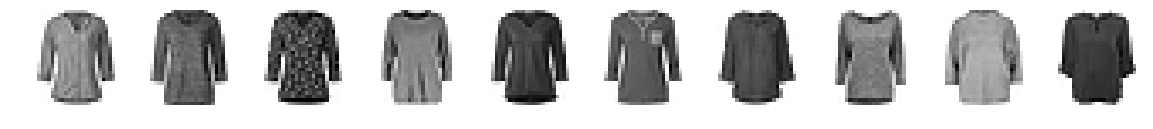

In [17]:
show_sim_image(4, 10)

(0, 0.0)
(9363, 0.005425501717345349)
(2874, 0.012666770791771476)
(1839, 0.01281209977641351)
(6069, 0.013060145927437761)
(4320, 0.013544160580537423)
(3692, 0.014531291393642731)
(5170, 0.014857561264718711)
(892, 0.015141115806666772)
(2761, 0.015862236349435732)


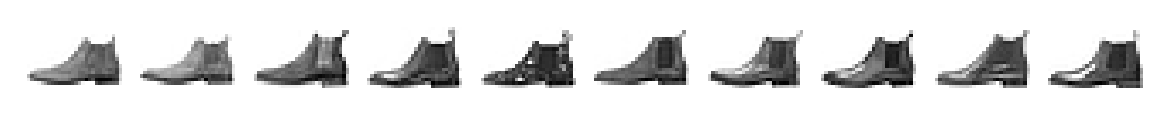

In [18]:
show_sim_image(0, 10)

# Visualization
ref: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/


In [19]:
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = os.path.join(os.getcwd(), log_dir, 'visualization')


if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

In [20]:
labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
with open(os.path.join(LOG_DIR, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(mnist.test.labels):
        f.write("%d\t%s\n" % (index, labels[np.argmax(label)]))

In [89]:
rows =[]
columns = []
sprite_size = int(np.sqrt(len(mnist.test.images)))

print("sprite image size {size} * {size}".format(**{"size": sprite_size}))

for img in mnist.test.images:
    img_ = 255 - np.reshape(img, [height, width]) # reshape and invert grayscale 
    rows.append(img_)

for i in range(sprite_size):
    columns.append(np.concatenate(rows[sprite_size * i : sprite_size * (i + 1)], axis=1))
    
image = np.concatenate(columns, axis=0).astype(np.uint8)
imageio.imwrite(os.path.join(LOG_DIR, 'sprite.png'), image)

sprite image size 100 * 100


In [25]:
embedding_var = tf.Variable(mnist.test.images, name='mnist_pixels')
config = projector.ProjectorConfig()

embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
embedding.sprite.image_path = os.path.join(LOG_DIR,  'sprite.png')
embedding.sprite.single_image_dim.extend([28, 28])

summary_writer = tf.summary.FileWriter(LOG_DIR)
projector.visualize_embeddings(summary_writer, config)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR,  'model.ckpt'), 0)

```
tensorboard --logdir=logs/visualization/
```

# tradesy data
http://jmcauley.ucsd.edu/data/tradesy/


In [193]:
from glob import glob
import scipy
import scipy.spatial
import scipy.misc
import operator
import pickle
import skimage
import skimage.transform
from skimage.color import rgb2gray

In [51]:
imgs = glob(os.path.join("./data/tradesy/images", "*.jpg"))
imgs = np.sort(imgs)

In [194]:
def imread(path):
    return imageio.imread(path)#.astype(np.float)

def get_resize_img(path, dim=28):
    img = imread(path)
    return skimage.transform.resize(img, [dim,dim, 3], mode="reflect")

def get_flatten_img(path, dim=28, invert_gray=False):
    if invert_gray:
        img = 255 - imread(path)
    else:
        img = imread(path)
    return rgb2gray(skimage.transform.resize(img, [dim, dim], mode="reflect"))

In [195]:
imageio.imread(imgs[0]).astype(np.float)

Image([[[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 254.,  254.,  254.],
        [ 254.,  254.,  254.],
        [ 254.,  254.,  254.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 254.,  254.,  254.],
        [ 254.,  254.,  254.],
        [ 254.,  254.,  254.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 254.,  254.,  254.],
        [ 254.,  254.,  254.],
        [ 254.,  254.,  254.]],

       ..., 
       [[ 254.,  254.,  252.],
        [ 254.,  254.,  252.],
        [ 254.,  254.,  252.],
        ..., 
        [ 255.,  254.,  255.],
        [ 255.,  254.,  255.],
        [ 255.,  254.,  255.]],

       [[ 254.,  254.,  252.],
        [ 254.,  254.,  252.],
        [ 254.,  254.,  252.],
        ..., 
        [ 255.,  254.,  255.],
        [ 255.,  254.,  255.],
        [ 

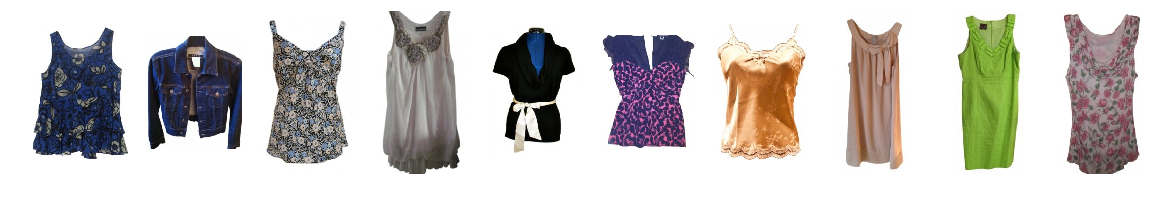

In [196]:
test = imgs[:10]
dim = 28
fig, axs = plt.subplots(1, len(test), figsize=(20, 3))
for i, path in enumerate(test):
        axs[i].imshow(imread(path), cmap='gray')
        axs[i].axis('off')
plt.show()

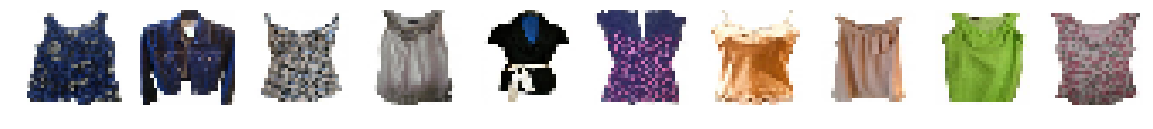

In [197]:
test = imgs[:10]
dim = 28
fig, axs = plt.subplots(1, len(test), figsize=(20, 3))
for i, path in enumerate(test):
        axs[i].imshow(get_resize_img(path,dim), cmap='gray')
        axs[i].axis('off')
plt.show()

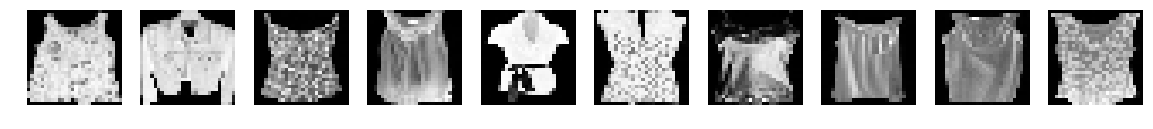

In [198]:
test = imgs[:10]
dim = 28
fig, axs = plt.subplots(1, len(test), figsize=(20, 3))
for i, path in enumerate(test):
        axs[i].imshow(get_flatten_img(path, invert_gray=True), cmap='gray')
        axs[i].axis('off')
plt.show()

In [199]:
get_resize_img(path, dim).shape

(28, 28, 3)

In [200]:
get_flatten_img(test[0], invert_gray=True).shape

(28, 28)

In [201]:
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = os.path.join(os.getcwd(), log_dir, 'visualization', "tradesy")

if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

In [209]:
test = imgs[:10000]

In [210]:
rows =[]
columns = []
sprite_size = int(np.sqrt(len(test)))
test_images = []
orig_images = []

print("sprite image size {size} * {size}".format(**{"size": sprite_size}))
rm_list = []
for path in tqdm(test):
    img_ = get_resize_img(path , dim) 
    if img_.shape != (28,28,3,):
        print(path)
        print(img_.shape)
        rm_list.append(path)
    else:
        test_images.append(get_flatten_img(path, invert_gray=True))
        orig_images.append(imread(path))
        rows.append(img_)
print(len(rows))
for i in tqdm(range(sprite_size)):
    columns.append(np.concatenate(rows[sprite_size * i : sprite_size * (i + 1)], axis=1))
    
image = np.concatenate(columns, axis=0)
imageio.imwrite(os.path.join(LOG_DIR, 'sprite.png'), image)
for path in rm_list:
    test = np.delete(test, np.argwhere(test==path))
len(test) 

sprite image size 100 * 100


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

Exception in thread Thread-14:
Traceback (most recent call last):
  File "/Users/tdual/anaconda2/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/tdual/anaconda2/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/tdual/anaconda2/envs/py36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




10000


HBox(children=(IntProgress(value=0), HTML(value='')))

/Users/tdual/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


10000

In [211]:
test_images = np.array(test_images)

In [212]:
test_images.shape

(10000, 28, 28)

In [213]:
test_images = np.reshape(test_images, [10000, 28*28])

In [214]:
with open(os.path.join(LOG_DIR, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(test):
        f.write("%d\t%s\n" % (index, label))

In [215]:
embedding_var = tf.Variable(test_images, name='mnist_pixels')
config = projector.ProjectorConfig()

embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
embedding.sprite.image_path = os.path.join(LOG_DIR,  'sprite.png')
embedding.sprite.single_image_dim.extend([28, 28])

summary_writer = tf.summary.FileWriter(LOG_DIR)
projector.visualize_embeddings(summary_writer, config)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR,  'model.ckpt'), 0)


```
tensorboard --logdir=logs/visualization/tradesy
```

In [216]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    h_fc1_ = sess.run(h_fc1, feed_dict={x: test_images})

In [217]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(h_fc1_, metric="cosine"))

In [218]:
def similar_to(img_id, num=5, distance=False):
    img = pairwise[img_id]
    ids = np.argsort(img)[0: num] 
    if distance:
        dist = np.sort(img)[0: num]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

def show_sim_image(img_id, num=5):
    id_list = similar_to(img_id, num=num,distance=True)
    fig, axs = plt.subplots(1, len(id_list), figsize=(20, 3))
    for i, id in enumerate(id_list):
        print(id)
        img =orig_images[id[0]]
        axs[i].imshow(img ,cmap='gray')
        axs[i].axis('off')
    plt.show()

(0, 0.0)
(3874, 0.011822970541119693)
(2757, 0.0123986256921087)
(6370, 0.012439819024036791)
(4362, 0.012579440113129059)
(2974, 0.012854551774248768)
(6981, 0.012868717868987134)
(6971, 0.012921307703956941)
(8654, 0.012958029881089517)
(7530, 0.013110500753357957)


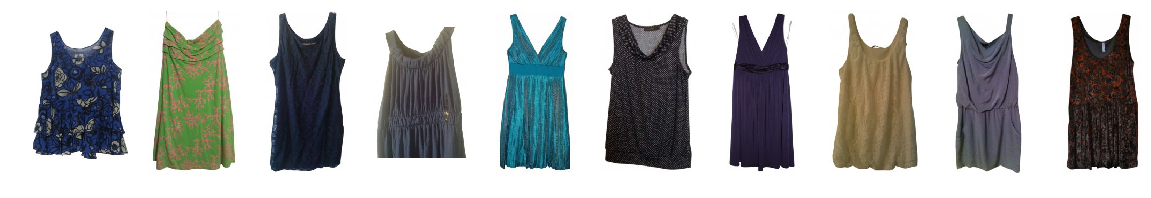

In [219]:
show_sim_image(0,10)

(1, 0.0)
(2504, 0.014192831421512175)
(7580, 0.014910989581219836)
(4072, 0.01506387653890251)
(8911, 0.016446444416836514)
(6274, 0.016716987437186859)
(1823, 0.016812265496931711)
(7396, 0.01682231451573768)
(7420, 0.01706058940815236)
(474, 0.017176612405637393)


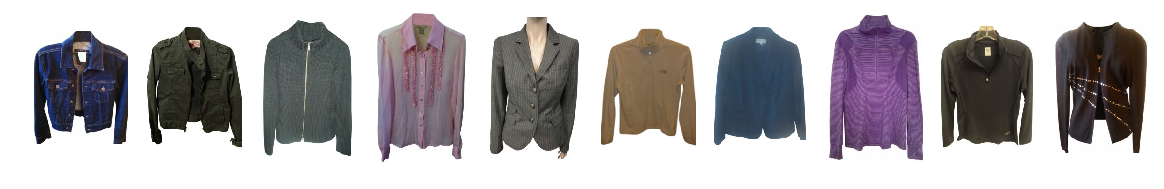

In [220]:
show_sim_image(1,10)